# Local Max-k-cut with FLIP


## Prepare environment

### Import libraries

In [8]:
import numpy as np
import networkx as nx
import networkx.drawing
import matplotlib.pyplot as plt
import time
from scipy import stats
from tabulate import tabulate
import multiprocessing as mp
import matplotlib.cm as cmx
import matplotlib.colors as matcolors
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

### Main functions

In [9]:
# Max-cut functions
def InitializeGraph(n, min_weight, max_weight, dropout):
    W = np.random.uniform(low=min_weight, high=max_weight, size=(n,n))
    if dropout>0:
        D = np.random.choice([0,1], size=(n,n), replace=True, p=[dropout, 1-dropout])
        W = np.multiply(W,D)
    # Copy upper diagonal to lower diagonal (only the upper perturbation counts)
    i_lower = np.tril_indices(n, -1)
    W[i_lower] = W.T[i_lower]
    # Make sure diagonal is empty
    np.fill_diagonal(W, 0)
    return W

def InitializeFlatGraph(n, min_weight, max_weight, dropout):
    W = np.random.uniform(low=min_weight, high=max_weight, size=n)
    if dropout>0:
        D = np.random.choice([0,1], size=n, replace=True, p=[dropout, 1-dropout])
        W = np.multiply(W,D)
    return W

def GetKRandomPartition(n, k):
    partition = {}
    for i in range(n):
        partition[i]=np.random.randint(low=0, high=k, size=1)[0]
    return partition

def Get0Partition(n):
    partition = {}
    for i in range(n):
        partition[i]=0
    return partition

def GetStupidPartition(n):
    partition = {}
    for i in range(n):
        partition[i]=-1
    return partition

def GetInitialPartition(n, k, initial_partition_type):
    if initial_partition_type == "random":
        initial_partition = GetKRandomPartition(n,k)
    if initial_partition_type == "0":
        initial_partition = Get0Partition(n)
    return initial_partition

def CutCost(W, partition, n, k):
    z = 0
    identity = np.identity(k)
    for i in range(n):
        for j in range(i, n):
            new_edge = (1-identity[partition[i], partition[j]])*W[i,j]
            z += new_edge
    return z
        
def CutGainAfterFlip(W, initial_partition, final_partition, n):
    # Vi: initial partition of the vertex v
    # Vj: final partition of the vertex v
    # z: current cut
    weights_to_add = 0
    weights_to_substract = 0
    
    diff_partition = {key: initial_partition[key] - final_partition.get(key, 0) for key in initial_partition}
    
    # v: vertex that flipped
    v = [key for key, val in diff_partition.items() if val!=0][0]
    v_old_partition = initial_partition[v]
    v_new_partition = final_partition[v]
    
    # Vertices belonging to the old group and the new group
    vertices_in_old_partition = [key  for (key, value) in initial_partition.items() if value == v_old_partition]
    vertices_in_new_partition = [key  for (key, value) in initial_partition.items() if value == v_new_partition]

    for vi in vertices_in_old_partition:
        if vi == v:
            continue
        else:
            weights_to_add += W[v, vi]
    for vj in vertices_in_new_partition:
        weights_to_substract += W[v, vj]
    z = weights_to_add - weights_to_substract
    return z
            
def SolveMaxCut(W, n, k, z, initial_partition, heuristic):
    tol = 1e-5
    maxIter = 10000
    it = 0
    
    zt1 = -10000
    zt2 = CutCost(W, initial_partition, n, k)
    
    # In case the cut is already optimal
    new_z = zt2
    
    # Store old and new partition
    old_partition = GetStupidPartition(n)
    new_partition = initial_partition
    
    start = time.time()
    if heuristic == "GBF":
        # Greedy Best Flip
        while(old_partition!=new_partition and it<maxIter):
            old_partition = new_partition
            new_partition, new_z = GreedyBestFlip(W, new_partition, n, k, zt2)
            zt1 = zt2
            zt2 = new_z
            it = it + 1
    elif heuristic == "RPF":
        # First Best Flip
         while(old_partition!=new_partition and it<maxIter):
            old_partition = new_partition
            new_partition, new_z = RandomPositiveFlip(W, new_partition, n, k, zt2)
            zt1 = zt2
            zt2 = new_z
            it = it + 1
    elif heuristic == "WF":
        # Worst Flip
         while(old_partition!=new_partition and it<maxIter):
            old_partition = new_partition
            new_partition, new_z = WorstFlip(W, new_partition, n, k, zt2)
            zt1 = zt2
            zt2 = new_z
            it = it + 1
    elif heuristic == "FNF":
        # First Next Flip
        # Only for testing purposes
        iters_fnf = 3
        for i in range(iters_fnf):
            partition, new_z = FirstNextFlip(W, partition, n, k, zt2)
            zt1 = zt2
            zt2 = new_z
            it = it + 1
            
    end = time.time()
    elapsed_time = np.round(end - start, 4)
    # The last step would return the same partition, so it-1
    return new_partition, new_z, elapsed_time, it-1

def SymmetricMatrix(W):
    m = len(W)
    n = int((1+np.sqrt(1+4*2*m))/2)
    A = np.zeros(shape=(n, n))
    # k runs along W
    k = 0
    # Fill upper diagonal
    for i in range(n-1):
        for j in range(i+1, n):
            A[i,j]=W[k]
            k+=1
    # Fill lower diagonal
    i_lower = np.tril_indices(n, -1)
    A[i_lower] = A.T[i_lower]
    return A

def NumpyToCsv(array, filename):
    np.savetxt(str(filename) + ".csv", array, delimiter=";")

def CsvToNumpy(filename):
    return np.genfromtxt(str(filename) + ".csv", delimiter=";")

### Meshgrid
def MeshGrid3dMaxCut(k, min_weight, max_weight, initial_partition_type, n_points_ax, n_iters, complexity, heuristic, sigma):
    weights_size = 3
    x = np.zeros(shape=(np.power(n_points_ax+1, 3), weights_size))
    f = np.zeros(np.power(n_points_ax+1, 3))
    # p runs over all points
    p = 0
    for i in range(n_points_ax+1):
        x_val = min_weight + (max_weight-min_weight)*i/n_points_ax
        for j in range(n_points_ax+1):
            y_val = min_weight + (max_weight-min_weight)*j/n_points_ax
            for l in range(n_points_ax+1):
                z_val = min_weight + (max_weight-min_weight)*l/n_points_ax
                w_flat = [x_val, y_val, z_val]
                w = SymmetricMatrix(w_flat)
                steps = np.zeros(n_iters)
                for it in range(n_iters):
                    initial_partition = GetInitialPartition(3, k, initial_partition_type)
                    initial_z = CutCost(w, initial_partition, 3, k)
                    if complexity == "average":
                        _p, _z, _t, steps[it] = SolveMaxCut(w, 3, k, initial_z, initial_partition, heuristic)
                    elif complexity == "smoothed":
                        # n_iters is also used for n_perturbations
                        steps[it] = SmoothedComplexity(w_flat, 3, k, initial_partition_type, 0, n_iters, heuristic, sigma)
                f[p] = np.mean(steps)
                x[p] = [x_val, y_val, z_val]
                p+=1
    return x, f

def PlotMeshGrid3d(x, f, title, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matcolors.Normalize(vmin=min(f), vmax=max(f))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x[:,0], x[:,1], x[:,2], c=scalarMap.to_rgba(f))
    plt.xticks(np.arange(min(x[:,0]), max(x[:,0])+1, 0.5))
    plt.yticks(np.arange(min(x[:,1]), max(x[:,1])+1, 0.5))
    scalarMap.set_array(f)
    fig.colorbar(scalarMap)
    if title:
        plt.title(title)
    plt.show()

### Plot results
def PlotGraph(G, partition = None):
    G = nx.from_numpy_matrix(W)
    pos = nx.spring_layout(G)
    # Draw the graph according to node positions
    if partition is not None:
        colors= np.fromiter(partition.values(), dtype=int)+1
        nx.draw(G, pos, with_labels=True, node_color=colors)
    else:
        nx.draw(G, pos, with_labels=True)
    # Create edge labels
    labels = nx.get_edge_attributes(G, 'weight')

    # Draw edge labels according to node positions
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

    plt.show()
    return

def PlotRegressionResults(nodes, steps_mean, steps_sd, with_errorbars, r_var, r_var_label, method):
    
    # Convert X axis according to method
    x = nodes
    if method=="polynomial":
        x = np.log(x.reshape(-1, 1))

    # t runs over all columns of steps_mean
    t=0
    slopes=[]
    intercepts=[]
    r_values=[]
    p_values=[]
    std_errs=[]

    # Create a new plot
    plt.figure(np.random.randint(501, 1000))
    
    for r_v in r_var:
        # Convert Y axis according to method
        y = steps_mean[:,t]
        if (method=="polynomial") or (method=="exponential"):
            y = np.log(y)
        plt.scatter(x, y)
        if with_errorbars:
            y_sd = steps_sd[:, t]
            plt.errorbar(x,y,yerr=y_sd, linestyle="None")

        # Linear regression
        slope, intercept, r_value, p_value, std_err = stats.mstats.linregress(x,y)

        # Store results
        slopes.append(slope)
        intercepts.append(intercept)
        r_values.append(r_value)
        p_values.append(p_value)
        std_errs.append(std_err)

        # Linear regression prediction
        y_reg = intercept + slope*x
        plt.plot(x, y_reg, label=str(r_var_label) + '=' + str(r_v))
        t+=1

    if method=="polynomial":
        plt.title('Polynomial behavior')     
        plt.xlabel('ln(Nodes)') 
        plt.ylabel('ln(Steps)')
    
    if method=="exponential":
        plt.title('Exponential behavior')     
        plt.xlabel('Nodes') 
        plt.ylabel('ln(Steps)')
    
    plt.legend()        
    plt.show()

    # Print table
    print("Regression results:\n")
    print(tabulate(list(zip(*[r_var, slopes, intercepts, r_values])), headers=[r_var_label, 'slope', 'intercept', 'r_value'], floatfmt=".3f"))
    
    return slopes, intercepts
    
def PlotResults(nodes, steps_mean, steps_sd, with_errorbars, r_var, r_var_label):
    #r_var is running variable
    
    # Show results for each r_var
    x = nodes.reshape(-1, 1)

    # Legend
    r_var_labels=[]

    # t runs over all columns of steps_mean
    t=0

    # Create a new plot
    plt.figure(np.random.randint(0, 500))
    
    for r_v in r_var:
        run_steps = steps_mean[:,t]
        
        plt.scatter(x, run_steps)
        if with_errorbars:
            run_steps_sd = steps_sd[:, t]
            plt.errorbar(x,run_steps,yerr=run_steps_sd, linestyle="None")
        r_var_labels.append(str(r_var_label) + "=" + str(r_v))
        t+=1

    plt.title('Steps vs. Nodes') 
    plt.xlabel('Nodes') 
    plt.ylabel('Steps')
    plt.legend(r_var_labels)
    plt.show()
    
def PlotResultsSmoothed(nodes, steps_mean, steps_sd, with_errorbars, r_var, r_var_label, sigma, withUpperBound):
    #r_var is running variable
    
    # Show results for each r_var
    x = nodes.reshape(-1, 1)

    # Legend
    r_var_labels=[]

    # t runs over all columns of steps_mean
    t=0
    
    # Create a new plot
    plt.figure(np.random.randint(1001, 1500))

    for r_v in r_var:
        run_steps = steps_mean[:,t]
        plt.scatter(x, run_steps)
        if with_errorbars:
            run_steps_sd = steps_sd[:, t]
            plt.errorbar(x,run_steps,yerr=run_steps_sd, linestyle="None")
        r_var_labels.append(str(r_var_label) + "=" + str(r_v))
        t+=1
    # Assume gaussian
    if withUpperBound:
        phi = 1/np.sqrt(2*np.pi*sigma*sigma)
        upper_bound = phi*np.power(nodes, 7.83)
        plt.plot(nodes, upper_bound, color='red', linewidth=1.0, linestyle='--')
    plt.title('Steps vs. Nodes') 
    plt.xlabel('Nodes') 
    plt.ylabel('Steps')
    plt.legend(r_var_labels)
    plt.show()

#### FLIP strategies

In [10]:
def GreedyBestFlip(W, partition, n, k, z):
    cut_costs = []
    partitions_flip = []
    # Permutate vertices so that we do not always start by the same one
    order = np.random.permutation(range(n))
    for i in order:
        for j in range(1, k):            
            new_partition = partition.copy()
            new_partition[i] = (new_partition[i]+j)%k
            partitions_flip.append(new_partition)
            cut_costs.append(CutGainAfterFlip(W, partition, new_partition, n))
      
    # Convert the list to a numpy array
    cut_costs = np.asarray(cut_costs)
    if np.any(cut_costs[cut_costs>0]):
        # New best partition was found
        best_index = np.argmax(cut_costs)
        best_partition = partitions_flip[best_index]
        new_cut_cost = z + cut_costs[best_index]
        return best_partition, new_cut_cost
    else:
        # We are in a local optimum
        return partition, z
    
def RandomPositiveFlip(W, partition, n, k, z):
    # Permutate vertices so that we do not always start by the same one
    order = np.random.permutation(range(n))
    for i in order:
        for j in range(1, k):            
            new_partition = partition.copy()
            new_partition[i] = (new_partition[i]+j)%k
            new_z = CutGainAfterFlip(W, partition, new_partition, n)
            if new_z > 0:
                return new_partition, z + new_z
      
    return partition, z

def WorstFlip(W, partition, n, k, z):
    cut_costs = []
    partitions_flip = []
    # Permutate vertices so that we do not always start by the same one
    order = np.random.permutation(range(n))
    for i in order:
        for j in range(1, k):            
            new_partition = partition.copy()
            new_partition[i] = (new_partition[i]+j)%k
            partitions_flip.append(new_partition)
            cut_costs.append(CutGainAfterFlip(W, partition, new_partition, n))
      
    # Convert the list to a numpy array
    cut_costs = np.asarray(cut_costs)
    
    if np.any(cut_costs[cut_costs>0]):
        # A better partition was found
        min_val = min(c for c in cut_costs if c > 0)
        worst_index = np.argwhere(cut_costs==min_val)[0][0]
        worst_partition = partitions_flip[worst_index]
        new_cut_cost = z + cut_costs[worst_index]
        return worst_partition, new_cut_cost
    else:
        # We are in a local optimum
        return partition, z

## Example instance

### Main parameters

C:\Users\kerik\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


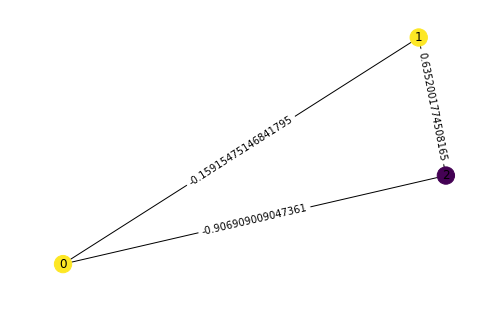

In [44]:
# Number of nodes
n = 3
# Number of partitions (k-cut)
k = 2

# Define min weight and max weight of the graph
min_weight=-1
max_weight=1

# Dropout
dropout = 0

# Initial values
W = InitializeGraph(n, min_weight, max_weight, dropout)
initial_partition = GetKRandomPartition(n, k)
initial_z = CutCost(W, initial_partition, n, k)

PlotGraph(W, initial_partition)

### Solve local Max-k-cut instance

#### Greedy Best Flip

Greedy Best Flip
Initial cut: 1.9886360299999999
Last cut: 4.0035966300000005
Number of steps: 2
Elapsed time: 0.0 s.



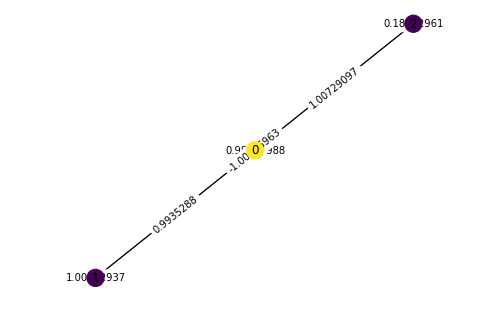

In [16]:
partition, z, elapsed_time, steps = SolveMaxCut(W, n, k, initial_z, initial_partition, "GBF")
print('Greedy Best Flip')
print('Initial cut: ' + str(initial_z))
print('Last cut: ' + str(z))
print('Number of steps: ' + str(steps))
print("Elapsed time: " + str(elapsed_time) + " s.\n")
PlotGraph(W, partition)

#### Random Positive Flip

Random Positive Flip
Initial cut: -0.2717088315965446
Last cut: 0.4760454259823985
Number of steps: 3
Elapsed time: 0.001 s.


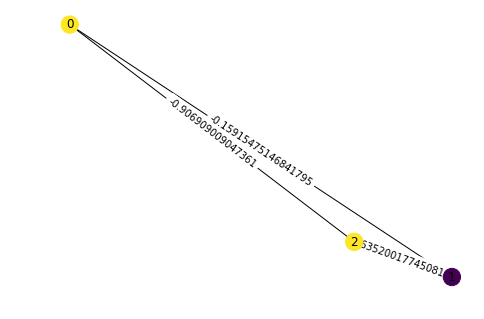

In [45]:
partition, z, elapsed_time, steps = SolveMaxCut(W, n, k, initial_z, initial_partition, "RPF")
print("Random Positive Flip")
print('Initial cut: ' + str(initial_z))
print('Last cut: ' + str(z))
print('Number of steps: ' + str(steps))
print("Elapsed time: " + str(elapsed_time) + " s.")
PlotGraph(W, partition)

#### Worst Flip

Worst Flip
Initial cut: 1.15
Last cut: 2.09
Number of steps: 5
Elapsed time: 0.004 s.


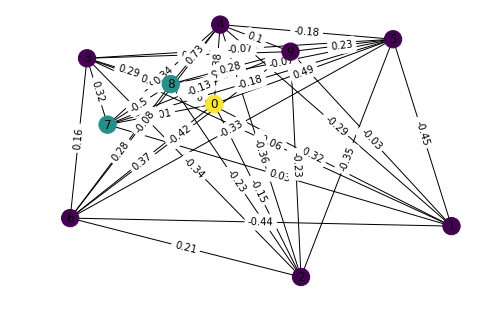

In [478]:
partition, z, elapsed_time, steps = SolveMaxCut(W, n, k, initial_z, initial_partition, "WF")
print("Worst Flip")
print('Initial cut: ' + str(initial_z))
print('Last cut: ' + str(z))
print('Number of steps: ' + str(steps))
print("Elapsed time: " + str(elapsed_time) + " s.")
PlotGraph(W, partition)

## Average complexity

### Main functions

In [133]:
def RunGridMaxCutAverageK(min_nodes, max_nodes, step_nodes, initial_partition_type, dropout, ks, min_weight, max_weight, iters_for_nk, heuristic):

    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)

    steps_mean = np.zeros((len(nodes), len(ks)))
    steps_sd = np.zeros((len(nodes), len(ks)))
    
    i = 0
    j = 0

    for ni in nodes:
        weights_size = int(ni*(ni-1)/2)
        for ki in ks:
            steps = np.zeros(iters_for_nk)
            for it in range(iters_for_nk):
                # Create graph and initial partition
                W_k_it = InitializeFlatGraph(weights_size, min_weight, max_weight, dropout)
                W_k_it = SymmetricMatrix(W_k_it)
                initial_partition = GetInitialPartition(ni, ki, initial_partition_type)
                # Get initial cost value
                initial_z = CutCost(W_k_it, initial_partition, ni, ki)
                # Get next local maximum
                partition, z, elapsed_time, n_steps = SolveMaxCut(W_k_it, ni, ki, initial_z, initial_partition, heuristic)
                # Save results for each iteration
                steps[it]=n_steps
             
            # Save results for a i,j combination    
            steps_mean[i,j] = np.mean(steps)
            steps_sd[i,j] = np.std(steps)/np.sqrt(iters_for_nk)
            j = j + 1
        j = 0
        i = i + 1
    return steps_mean, steps_sd, nodes

def RunGridMaxCutAverageDropout(min_nodes, max_nodes, step_nodes, initial_partition_type, dropouts, k, min_weight, max_weight, iters_for_nk, heuristic):

    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)

    steps_mean = np.zeros((len(nodes), len(dropouts)))
    steps_sd = np.zeros((len(nodes), len(dropouts)))
    
    i = 0
    j = 0

    for ni in nodes:
        for d in dropouts:
            steps = np.zeros(iters_for_nk)
            for it in range(iters_for_nk):
                # Create graph and initial partition
                W = InitializeGraph(ni, min_weight, max_weight, d)
                initial_partition = GetInitialPartition(ni, k, initial_partition_type)
                # Get initial cost value
                initial_z = CutCost(W, initial_partition, ni, k)
                # Get next local maximum
                partition, z, elapsed_time, n_steps = SolveMaxCut(W, ni, k, initial_z, initial_partition, heuristic)
                # Save results for each iteration
                steps[it]=n_steps
                
            # Save results for a i,j combination    
            steps_mean[i,j] = np.mean(steps)
            steps_sd[i,j] = np.std(steps)/np.sqrt(iters_for_nk)
            j = j + 1
        j = 0
        i = i + 1
    return steps_mean, steps_sd, nodes

def RunGridMaxCutAverageHeuristics(min_nodes, max_nodes, step_nodes, initial_partition_type, dropout, k, min_weight, max_weight, iters_for_nk, heuristics):

    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)

    steps_mean = np.zeros((len(nodes), len(heuristics)))
    steps_sd = np.zeros((len(nodes), len(heuristics)))
    
    i = 0
    j = 0

    for ni in nodes:
        for h in heuristics:
            steps = np.zeros(iters_for_nk)
            for it in range(iters_for_nk):
                # Create graph and initial partition
                W = InitializeGraph(ni, min_weight, max_weight, dropout)
                initial_partition = GetInitialPartition(ni, k, initial_partition_type)
                # Get initial cost value
                initial_z = CutCost(W, initial_partition, ni, k)
                # Select method
                partition, z, elapsed_time, n_steps = SolveMaxCut(W, ni, k, initial_z, initial_partition, h)
                # Save results for each iteration
                steps[it]=n_steps
                
            # Save results for a i,j combination    
            steps_mean[i,j] = np.mean(steps)
            steps_sd[i,j] = np.std(steps)/np.sqrt(iters_for_nk)
            j = j + 1
        j = 0
        i = i + 1
    return steps_mean, steps_sd, nodes

### Complete graph

#### Weight space for n = 3

##### Main parameters

In [103]:
# n = 3

# Number of partitions (k-cut)
ks = [2, 3]

# Define min weight and max weight of the graph
min_weight=-1
max_weight=1

# Number of points per axis
n_points_ax = 10

# How many times run with new partition
n_iters = 2

# Dropout
dropout = 0

# heuristic
heuristic = "GBF"

# complexity
complexity = "average"

# Only useful if smoothed
sigma = 0

##### Run and show results for 0 partition

<IPython.core.display.Javascript object>


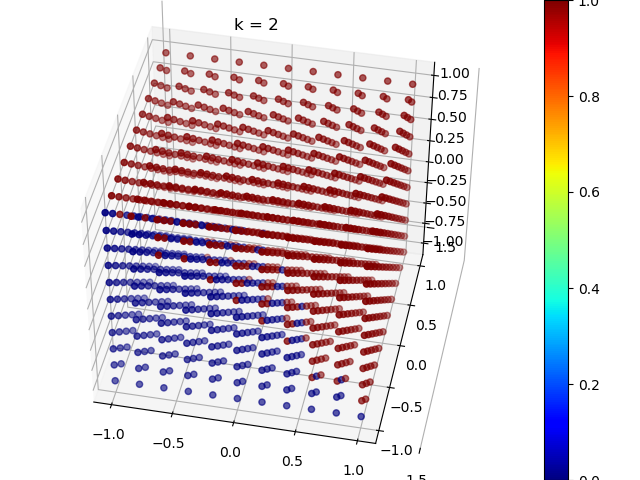

<IPython.core.display.Javascript object>


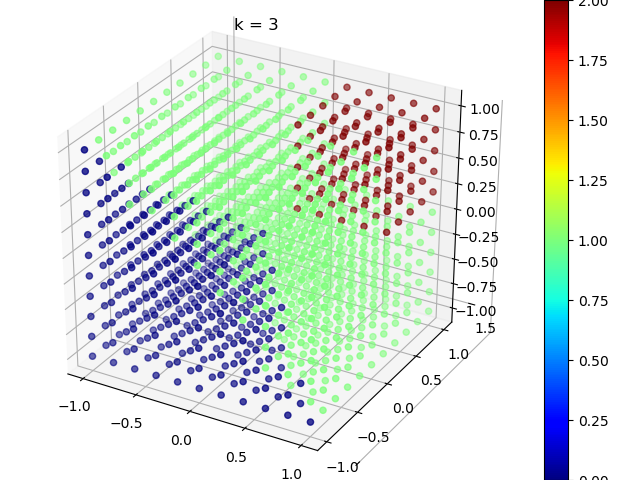

In [104]:
initial_partition_type = "0"
for k in ks:
    x, f = MeshGrid3dMaxCut(k, min_weight, max_weight, initial_partition_type, n_points_ax, n_iters, complexity, heuristic, sigma)
    title = "k = " + str(k)
    PlotMeshGrid3d(x, f, title)

##### Run and show results for random partition

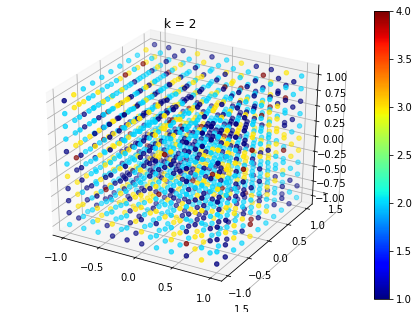

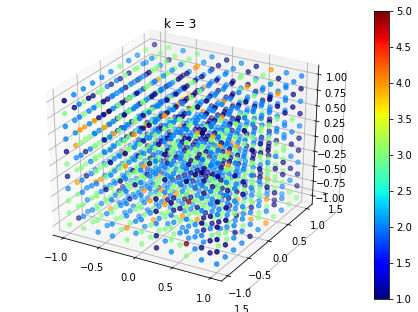

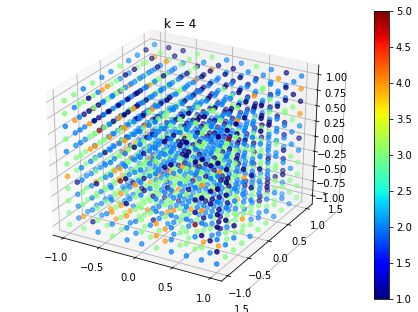

In [20]:
initial_partition_type = "random"
for k in ks:
    x, f = MeshGrid3dMaxCut(k, min_weight, max_weight, initial_partition_type, n_points_ax, n_iters, complexity, heuristic, sigma)
    title = "k = " + str(k)
    PlotMeshGrid3d(x, f, title)

#### Dependency on k

##### Main parameters

In [127]:
## Define grid parameters
# Nodes
min_nodes = 5
max_nodes = 20
num_nodes = 3

# Dropout assumed to be 0
dropout = 0

# K-cuts
ks=[2, 3]

# Number of instances for each combination
iters_for_nk=10

# Method
method = "GBF"

# Initial partition:
initial_partition_type = "random"

##### Run

In [128]:
steps_mean, steps_sd, nodes = RunGridMaxCutAverageK(
    min_nodes, max_nodes, num_nodes, initial_partition_type, dropout, ks, min_weight, max_weight, iters_for_nk, method)

##### Show results

<IPython.core.display.Javascript object>


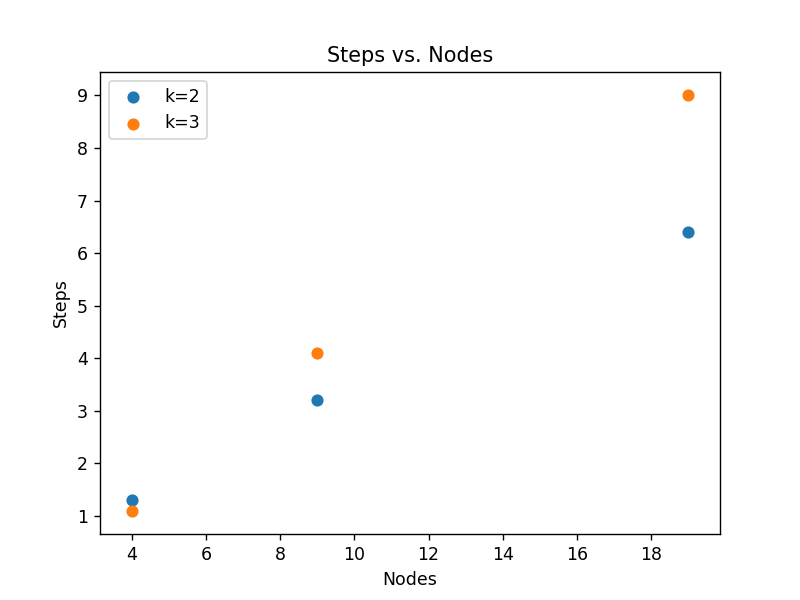

In [129]:
PlotResults(nodes, steps_mean, steps_sd, False, ks, 'k')

##### Polynomial behavior

In [ ]:
slopes, intercepts = PlotRegressionResults(nodes, steps_mean, steps_sd, False, ks, 'k', "polynomial")

##### Exponential behavior

In [ ]:
slopes, intercepts = PlotRegressionResults(nodes, steps_mean, steps_sd, False, ks, 'k', "exponential")

#### Dependency on heuristics

##### Main parameters

In [138]:
## Define grid parameters
# Nodes
min_nodes = 5
max_nodes = 50
num_nodes = 10

# Dropout assumed to be 0
dropout = 0

# K-cuts
k=2

# Number of instances for each combination
iters_for_nk=20

# Method
methods = ["GBF", "RPF", "WF"]

# Initial partition
initial_partition_Type = "0"

##### Run

In [139]:
steps_mean, steps_sd, nodes = RunGridMaxCutAverageHeuristics(
    min_nodes, max_nodes, num_nodes, initial_partition_type, dropout, k, min_weight, max_weight, iters_for_nk, methods)

In [144]:
np.savetxt("steps_mean.csv", steps_mean, delimiter=";")
steps_mean2 = np.genfromtxt("steps_mean.csv", delimiter=";")

[[  0.95   1.9    1.85]
 [  2.1    2.4    4.2 ]
 [  2.7    3.85   7.6 ]
 [  3.65   5.45  11.9 ]
 [  4.9    6.85  18.25]
 [  5.95   9.5   24.7 ]
 [  7.7   10.85  47.35]
 [ 10.05  16.95  82.55]
 [ 14.8   21.5  132.55]
 [ 17.7   31.05 206.65]]
[[  0.95   1.9    1.85]
 [  2.1    2.4    4.2 ]
 [  2.7    3.85   7.6 ]
 [  3.65   5.45  11.9 ]
 [  4.9    6.85  18.25]
 [  5.95   9.5   24.7 ]
 [  7.7   10.85  47.35]
 [ 10.05  16.95  82.55]
 [ 14.8   21.5  132.55]
 [ 17.7   31.05 206.65]]


##### Show results

<IPython.core.display.Javascript object>


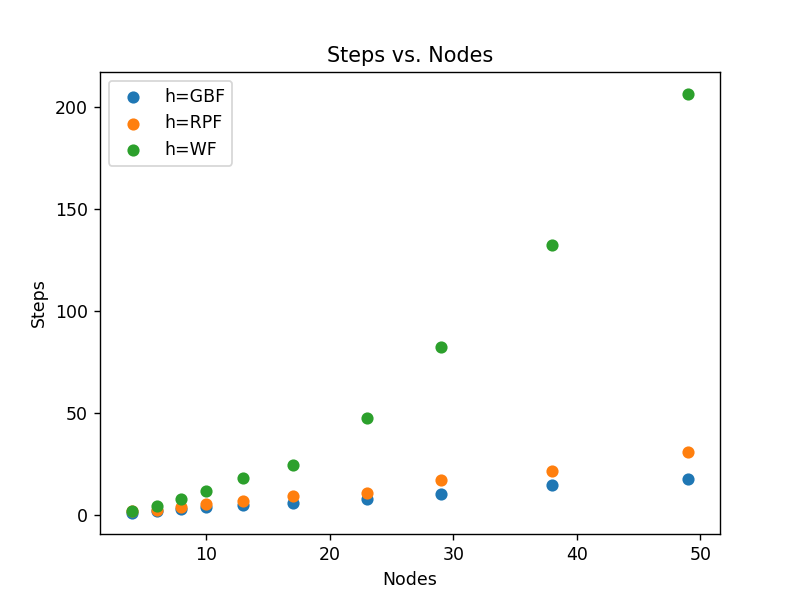

In [140]:
PlotResults(nodes, steps_mean, steps_sd, False, methods, 'h')

##### Polynomial behavior

<IPython.core.display.Javascript object>


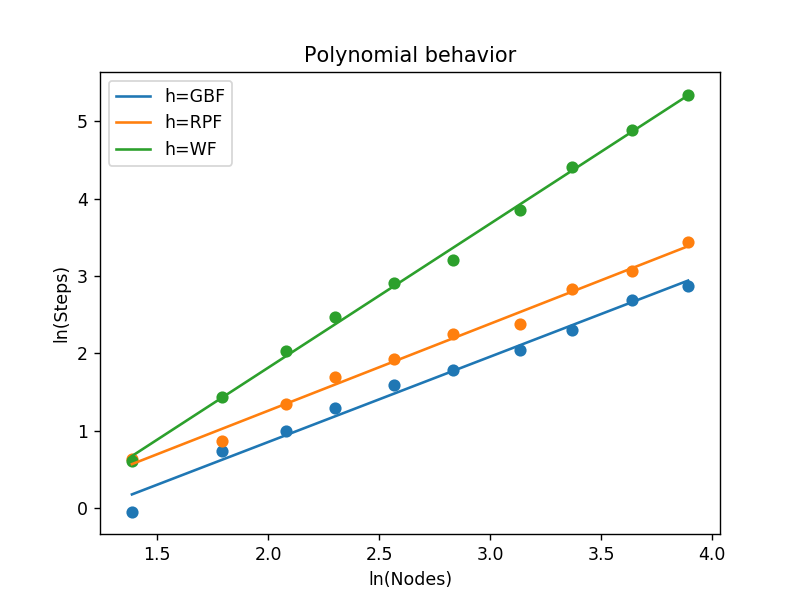

Regression results:

h      slope    intercept    r_value
---  -------  -----------  ---------
GBF    1.102       -1.347      0.993
RPF    1.123       -0.985      0.996
WF     1.859       -1.901      0.999


In [141]:
slopes, intercepts = PlotRegressionResults(nodes, steps_mean, steps_sd, False, methods, 'h', "polynomial")

##### Exponential behavior

<IPython.core.display.Javascript object>


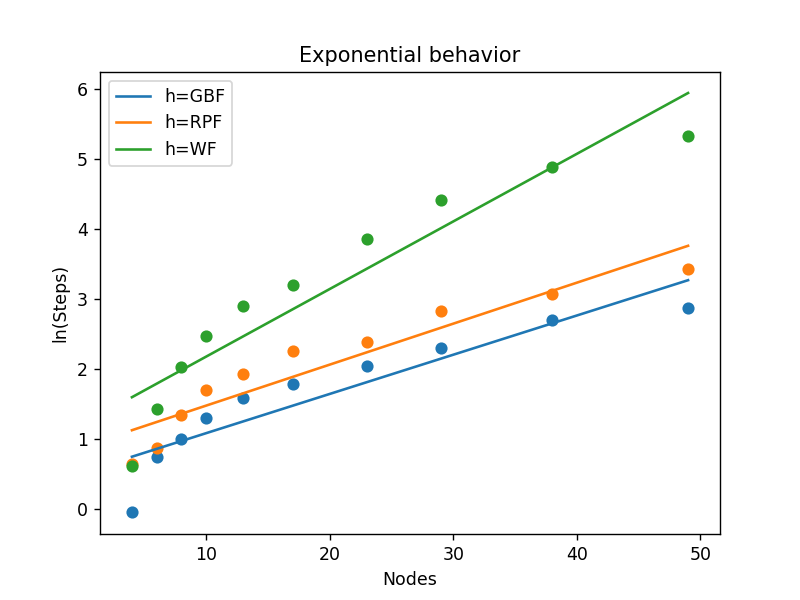

Regression results:

h      slope    intercept    r_value
---  -------  -----------  ---------
GBF    0.056        0.521      0.920
RPF    0.059        0.890      0.946
WF     0.097        1.210      0.946


In [142]:
slopes, intercepts = PlotRegressionResults(nodes, steps_mean, steps_sd, False, methods, 'h', "exponential")

### Partial graph (dropout)

#### Main parameters

In [150]:
# Nodes
min_nodes = 5
max_nodes = 100
num_nodes = 20

#min_weight and max_weight
min_weight=-1
max_weight=1

# List of dropouts
dropouts = np.round(np.linspace(0,0.9,5),2)

# K-cut
k=2

# Number of instances for each combination
iters_for_nk=30

# Method
heuristic = "RPF"

# Initial partition
initial_partition_type = "0"

#### Run

In [151]:
steps_mean, steps_sd, nodes = RunGridMaxCutAverageDropout(
    min_nodes, max_nodes, num_nodes, initial_partition_type, dropouts, k, min_weight, max_weight, iters_for_nk, heuristic)

#### Show results

<IPython.core.display.Javascript object>


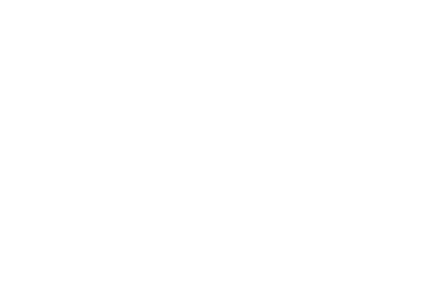

In [152]:
PlotResults(nodes, steps_mean, steps_sd, False, dropouts, 'd')

#### Polynomial behavior

<IPython.core.display.Javascript object>


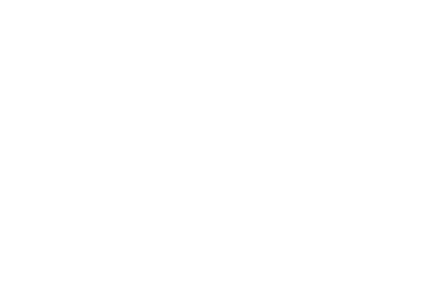

Regression results:

  dropout    slope    intercept    r_value
---------  -------  -----------  ---------
    0.000    1.035       -0.593      0.998
    0.220    1.041       -0.626      0.998
    0.450    1.035       -0.618      0.999
    0.680    1.071       -0.834      0.999
    0.900    1.198       -1.549      0.997


In [153]:
slopes, intercepts = PlotRegressionResults(nodes, steps_mean, steps_sd, False, dropouts, 'dropout', "polynomial")

#### Exponential behavior

<IPython.core.display.Javascript object>


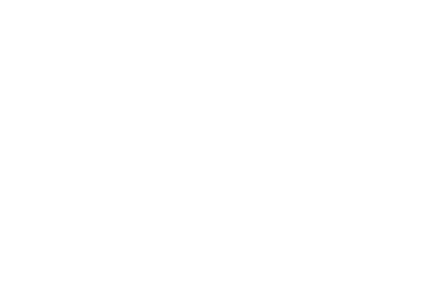

Regression results:

  dropout    slope    intercept    r_value
---------  -------  -----------  ---------
    0.000    0.033        1.497      0.939
    0.220    0.033        1.486      0.932
    0.450    0.033        1.491      0.925
    0.680    0.034        1.339      0.932
    0.900    0.038        0.892      0.925


In [154]:
slopes, intercepts = PlotRegressionResults(nodes, steps_mean, steps_sd, False, dropouts, 'dropout', "exponential")

## Smoothed complexity

### Main functions

In [ ]:
from scipy.optimize import basinhopping
     
def SmoothedComplexity(W, n, k, initial_partition_type, dropout, iters_for_perturbation, heuristic, sigma):
    ####### IMPORTANT ########
    # It always returns the NEGATIVE smoothed complexity #
    # Convert to proper shape
    Wi = SymmetricMatrix(W)
    # Initialize results
    steps = np.zeros(iters_for_perturbation)
    for it in range(iters_for_perturbation):
        # Create weight matrix
        W_k_it = Wi
        # Add perturbation
        if sigma > 0:
            perturbation = np.random.normal(loc=0, scale=sigma, size=(n,n))
            W_k_it = Wi + perturbation
        # Make sure that the elements are in range (-1, 1)
        W_k_it[W_k_it > 1] = 1
        W_k_it[W_k_it < -1] = -1
        # Copy upper diagonal to lower diagonal (only the upper perturbation counts)
        i_lower = np.tril_indices(n, -1)
        W_k_it[i_lower] = W_k_it.T[i_lower]
        # Make sure that diagonal is 0
        np.fill_diagonal(W_k_it, 0)
        # Perform a dropout
        if dropout>0:
            D = np.random.choice([0,1], size=(n,n), replace=True, p=[dropout, 1-dropout])
            W = np.multiply(W,D)
        # Get initial partition randomly
        initial_partition = GetInitialPartition(n, k, initial_partition_type)
        # Get initial cost value
        initial_z = CutCost(W_k_it, initial_partition, n, k)
        # Get next local maximum
        partition, z, elapsed_time, n_steps = SolveMaxCut(W_k_it, n, k, initial_z, initial_partition, heuristic)
        # Save results
        # times += elapsed_time
        steps[it]=n_steps
        # Think of another measure of the gap
    step_means = np.mean(steps)
    return -1*step_means

def BasinHoppingSmoothedComplexityK(min_nodes, max_nodes, step_nodes, initial_partition_type, ks, dropout, 
                                  min_weight, max_weight, iters_for_nk, heuristic, sigma, n_iterations):
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    smoothed_complexities = np.zeros((len(nodes), len(ks)))
    
    # Running variables
    i = 0
    j = 0
    
    for ni in nodes:
        # Define weight size (upper diagonal)
        weights_size = int(ni*(ni-1)/2)
        # Create boundaries
        bound = (-1., 1.)
        bounds = []
        for m in range(weights_size):
            bounds.append(bound)
        bounded_step = RandomDisplacementBounds(np.array([b[0] for b in bounds]), np.array([b[1] for b in bounds]))
        for ki in ks:
            #Initial guess of size ni(ni-1)/2
            W0 = InitializeFlatGraph(weights_size, -1, 1, dropout)
            # Initialize kwargs
            minimizer_kwargs = {"args": (ni, ki, initial_partition_type, dropout, iters_for_nk, heuristic, sigma), "bounds": bounds}
            ret = basinhopping(SmoothedComplexity, W0, disp = False, minimizer_kwargs=minimizer_kwargs, niter=n_iterations, take_step=bounded_step)
            smoothed_complexities[i, j] = ret.fun
            j = j + 1
        j = 0
        i = i + 1
    return nodes, -1*smoothed_complexities

def RandomGridSmoothedComplexityK(min_nodes, max_nodes, step_nodes, initial_partition_type, ks, dropout, 
                                  min_weight, max_weight, iters_for_nk, iters_for_w,heuristic, sigma):
    
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    step_means = np.zeros(iters_for_w)
    smoothed_complexities = np.zeros((len(nodes), len(ks)))
       
    # Running variables
    i = 0
    j = 0
    
    for ni in nodes:
        # Define weight size (upper diagonal)
        weights_size = int(ni*(ni-1)/2)
        for ki in ks:
            for w in range(iters_for_w):
                W = InitializeFlatGraph(weights_size, min_weight, max_weight, dropout)
                # Initialize results
                steps = np.zeros(iters_for_nk)
                for nk in range(iters_for_nk):
                    # Create perturbation
                    perturbation = np.random.normal(loc=0, scale=sigma, size=weights_size)
                    W_k_it = W + perturbation
                    # Perform a dropout
                    if dropout>0:
                        D = np.random.choice([0,1], size=weights_size, replace=True, p=[dropout, 1-dropout])
                        W_k_it = np.multiply(W_k_it,D)
                    # Convert to symmetric matrix
                    W_k_it = SymmetricMatrix(W_k_it)
                    # Get initial partition randomly
                    initial_partition = GetInitialPartition(ni, ki, initial_partition_type)
                    # Get initial cost value
                    initial_z = CutCost(W_k_it, initial_partition, ni, ki)
                    # Get next local maximum
                    partition, z, elapsed_time, n_steps = SolveMaxCut(W_k_it, ni, ki, initial_z, initial_partition, heuristic)
                    # Save results
                    # times += elapsed_time
                    steps[nk]=n_steps
                    # Think of another measure of the gap
                step_means[w] = np.mean(steps)
            smoothed_complexities[i,j] = np.max(step_means)
            j = j + 1
        i = i + 1
        j = 0
    
    return nodes, smoothed_complexities

def RandomGridSmoothedComplexityParallelK(min_nodes, max_nodes, step_nodes, initial_partition_type, ks, dropout, 
                                  min_weight, max_weight, n_perturbations, tries, heuristic, sigma):
    
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    smoothed_complexities = np.zeros((len(nodes), len(ks)))
       
    # Running variables
    i = 0
    j = 0
    best_result = 0
    
    for ni in nodes:
        # Define weight size (upper diagonal)
        weights_size = int(ni*(ni-1)/2)
        for ki in ks:
            start = time.time()
            for t in range(tries):
                if (__name__ == '__main__'):       
                    N = mp.cpu_count()
                    # Define an output queue
                    output = mp.Manager().Queue()
                    processes = [mp.Process(target=RunRandomSmoothedComplexity, 
                                            args=(ni, min_weight, max_weight, dropout, initial_partition_type,
                                                  ki, n_perturbations, heuristic, sigma, t, output)) 
                                 for n_p in range(n_perturbations)]
                    # Start processes
                    for p in processes:
                        p.start()

                    # Exit the completed processes
                    for p in processes:
                        p.join()

                    # Get process results from the output queue
                    results = [output.get() for p in processes]
                    results_values = []
                    for l in range(len(results)):
                        results_values.append(results[l][-1])

                iter_result = np.max(results_values)
                best_index = np.argmax(results_values)
                end = time.time()
                if iter_result > best_result:
                    best_result = iter_result
        
            smoothed_complexities[i,j] = best_result
            
            print("Best result for n=" + str(ni) + " and k=" + str(ki) + " is " + str(best_result))
            end = time.time()
            print("Elapsed time: " + str(np.round((end-start), 2)) + " s.")
            best_result = 0
            j = j + 1
        i = i + 1
        j = 0
    
    return nodes, smoothed_complexities

def RandomSearchSmoothedComplexitySigmas(min_nodes, max_nodes, step_nodes, initial_partition_type, k, dropout, 
                                  min_weight, max_weight, iters_for_nk, iters_for_w, heuristic, sigmas):
    
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    step_means = np.zeros(iters_for_w)
    smoothed_complexities = np.zeros((len(nodes), len(sigmas)))
       
    # Running variables
    i = 0
    j = 0
    
    for ni in nodes:
        # Define weight size (upper diagonal)
        weights_size = int(ni*(ni-1)/2)
        for s in sigmas:
            for w in range(iters_for_w):
                W = InitializeFlatGraph(weights_size, min_weight, max_weight, dropout)
                # Initialize results
                steps = np.zeros(iters_for_nk)
                for nk in range(iters_for_nk):
                    # Create perturbation
                    perturbation = np.random.normal(loc=0, scale=s, size=weights_size)
                    W_k_it = W + perturbation
                    # Perform a dropout
                    if dropout>0:
                        D = np.random.choice([0,1], size=weights_size, replace=True, p=[dropout, 1-dropout])
                        W_k_it = np.multiply(W_k_it,D)
                    # Convert to symmetric matrix
                    W_k_it = SymmetricMatrix(W_k_it)
                    # Get initial partition randomly
                    initial_partition = GetInitialPartition(ni, k, initial_partition_type)
                    # Get initial cost value
                    initial_z = CutCost(W_k_it, initial_partition, ni, k)
                    # Get next local maximum
                    partition, z, elapsed_time, n_steps = SolveMaxCut(W_k_it, ni, k, initial_z, initial_partition, heuristic)
                    # Save results
                    # times += elapsed_time
                    steps[nk]=n_steps
                    # Think of another measure of the gap
                step_means[w] = np.mean(steps)
            smoothed_complexities[i,j] = np.max(step_means)
            j = j + 1
        i = i + 1
        j = 0
    
    return nodes, smoothed_complexities

def RandomSearchSmoothedComplexityDropout(min_nodes, max_nodes, step_nodes, initial_partition_type, k, dropouts, 
                                  min_weight, max_weight, iters_for_nk, iters_for_w, heuristic, sigma):
    
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    step_means = np.zeros(iters_for_w)
    smoothed_complexities = np.zeros((len(nodes), len(dropouts)))
       
    # Running variables
    i = 0
    j = 0
    
    for ni in nodes:
        # Define weight size (upper diagonal)
        weights_size = int(ni*(ni-1)/2)
        for d in dropouts:
            for w in range(iters_for_w):
                W = InitializeFlatGraph(weights_size, min_weight, max_weight, dropout)
                # Initialize results
                steps = np.zeros(iters_for_nk)
                for nk in range(iters_for_nk):
                    # Create perturbation
                    perturbation = np.random.normal(loc=0, scale=sigma, size=weights_size)
                    W_k_it = W + perturbation
                    # Perform a dropout
                    if d>0:
                        D = np.random.choice([0,1], size=weights_size, replace=True, p=[d, 1-d])
                        W_k_it = np.multiply(W_k_it,D)
                    # Convert to symmetric matrix
                    W_k_it = SymmetricMatrix(W_k_it)
                    # Get initial partition randomly
                    initial_partition = GetInitialPartition(ni, k, initial_partition_type)
                    # Get initial cost value
                    initial_z = CutCost(W_k_it, initial_partition, ni, k)
                    # Get next local maximum
                    partition, z, elapsed_time, n_steps = SolveMaxCut(W_k_it, ni, k, initial_z, initial_partition, heuristic)
                    # Save results
                    # times += elapsed_time
                    steps[nk]=n_steps
                    # Think of another measure of the gap
                step_means[w] = np.mean(steps)
            smoothed_complexities[i,j] = np.max(step_means)
            j = j + 1
        i = i + 1
        j = 0
    
    return nodes, smoothed_complexities

def RandomSearchSmoothedComplexityHeuristics(min_nodes, max_nodes, step_nodes, initial_partition_type, k, dropout, 
                                  min_weight, max_weight, iters_for_nk, iters_for_w, heuristics, sigma):
    
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    step_means = np.zeros(iters_for_w)
    smoothed_complexities = np.zeros((len(nodes), len(heuristics)))
       
    # Running variables
    i = 0
    j = 0
    
    for ni in nodes:
        # Define weight size (upper diagonal)
        weights_size = int(ni*(ni-1)/2)
        for h in heuristics:
            for w in range(iters_for_w):
                W = InitializeFlatGraph(weights_size, min_weight, max_weight, dropout)
                # Initialize results
                steps = np.zeros(iters_for_nk)
                for nk in range(iters_for_nk):
                    # Create perturbation
                    perturbation = np.random.normal(loc=0, scale=sigma, size=weights_size)
                    W_k_it = W + perturbation
                    # Perform a dropout
                    if dropout>0:
                        D = np.random.choice([0,1], size=weights_size, replace=True, p=[dropout, 1-dropout])
                        W_k_it = np.multiply(W_k_it,D)
                    # Convert to symmetric matrix
                    W_k_it = SymmetricMatrix(W_k_it)
                    # Get initial partition randomly
                    initial_partition = GetInitialPartition(ni, k, initial_partition_type)
                    # Get initial cost value
                    initial_z = CutCost(W_k_it, initial_partition, ni, k)
                    # Get next local maximum
                    partition, z, elapsed_time, n_steps = SolveMaxCut(W_k_it, ni, k, initial_z, initial_partition, h)
                    # Save results
                    # times += elapsed_time
                    steps[nk]=n_steps
                    # Think of another measure of the gap
                step_means[w] = np.mean(steps)
            smoothed_complexities[i,j] = np.max(step_means)
            j = j + 1
        i = i + 1
        j = 0
    
    return nodes, smoothed_complexities

def DecayLearningRate(e0, decay, iters):
    e = e0
    iters = iters + 1
    e = e0/(1+decay*iters)
    return e

def RandomOptimizationSmoothedComplexityK(min_nodes, max_nodes, step_nodes, initial_partition_type, ks, 
                                  min_weight, max_weight, iters, tries, heuristic, iters_for_perturbation, e0, decay, sigma):
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    smoothed_complexities = np.zeros((len(nodes), len(ks)))
       
    # Running variables
    i = 0
    j = 0

    # Define first learning rate
    
    best_result = 0

    for ni in nodes:
        # Define weight size (upper diagonal)
        weights_size = int(ni*(ni-1)/2)
        for ki in ks:
            # First guess
            x = InitializeFlatGraph(weights_size, min_weight, max_weight, dropout)
            e = e0
            for it in range(iters):          
                for t in range(tries):
                    # Create perturbation
                    perturbation = np.random.normal(loc=0, scale=e, size=weights_size)
                    x_t = x + perturbation
                    # Make sure elements stay within range
                    x_t[x_t > 1] = 1
                    x_t[x_t < -1] = -1
                    # Convert to symmetric matrix
                    W_k_it = SymmetricMatrix(x_t)
                    # Get initial partition randomly
                    initial_partition = GetInitialPartition(ni, ki, initial_partition_type)
                    # Get initial cost value
                    initial_z = CutCost(W_k_it, initial_partition, ni, ki)
                    # Get next local maximum
                    result = -1*(SmoothedComplexity(x_t, ni, ki, initial_partition_type, 0, iters_for_perturbation, heuristic, sigma))
                    # Save results
                    if result>best_result:
                        best_result = result
                        best_x = x_t
                e = DecayLearningRate(e0, decay, iters)
            smoothed_complexities[i,j] = best_result
            print("Best result for n=" + str(ni) + " and k=" + str(ki) + " is " + str(best_result))
            best_result = 0
            j = j + 1
        i = i + 1
        j = 0
    
    return nodes, smoothed_complexities 

def RandomOptimizationSmoothedComplexityParallelK(min_nodes, max_nodes, step_nodes, initial_partition_type, ks, 
                                  min_weight, max_weight, iters_max, tries, heuristic, iters_for_perturbation, e0, decay, sigma):
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    smoothed_complexities = np.zeros((len(nodes), len(ks)))
       
    # Running variables
    i = 0
    j = 0

    # Tolerance
    tol = 1e-4

    # Initiliaze
    best_result = 0
    e = e0
    
    for ni in nodes:
        # Define weight size (upper diagonal)
        weights_size = int(ni*(ni-1)/2)
        for ki in ks:
            # First guess
            x = InitializeFlatGraph(weights_size, min_weight, max_weight, dropout)
            it = 0
            start = time.time()
            while(it<iters_max):
                print("It " + str(it))
                #N = tf.contrib.eager.num_gpus()
                N = mp.cpu_count()
                #print("N of cpu count = ")
                #print(N)
                if (__name__ == '__main__'):
                    
                    # Define an output queue
                    output = mp.Manager().Queue()
                    processes = [mp.Process(target=RunSmoothedComplexity, 
                                            args=(x, ni, initial_partition_type, ki, e, iters_for_perturbation, heuristic, sigma, t, output)) 
                                 for t in range(tries)]
                    # Start processes
                    for p in processes:
                        p.start()

                    # Exit the completed processes
                    for p in processes:
                        p.join()

                    # Get process results from the output queue
                    results = [output.get() for p in processes]
                    results_values = []
                    results_x = []
                    for l in range(len(results)):
                        results_values.append(results[l][-1])
                        results_x.append(results[l][:-1])

                iter_result = np.max(results_values)
                best_index = np.argmax(results_values)
                end = time.time
                if iter_result > best_result:
                    best_result = iter_result
                    x = results_x[best_index]
                    e = DecayLearningRate(e0, decay, it)
                else:
                  break
                it+=1
                
            smoothed_complexities[i,j] = best_result
            print("Best result for n=" + str(ni) + " and k=" + str(ki) + " is " + str(best_result))
            end = time.time()
            print("Elapsed time: " + str(np.round((end-start), 2)) + " s.")
            best_result = 0            
            j = j + 1
        i = i + 1
        j = 0
    
    return nodes, smoothed_complexities
        
def RunSmoothedComplexity(x, n, initial_partition_type, k, e, iters_for_perturbation, heuristic, sigma, seed, output):
    # Weights size is the length of x
    weights_size = len(x)
    # Create perturbation
    local_state = np.random.RandomState(seed)
    # Store weights
    x_t = x
    if sigma > 0:
        perturbation = local_state.normal(loc=0, scale=e, size=weights_size)
        x_t = x + perturbation
    # Make sure elements stay within range
    x_t[x_t > 1] = 1
    x_t[x_t < -1] = -1
    # Convert to symmetric matrix
    W_k_it = SymmetricMatrix(x_t)
    # Get initial partition randomly
    initial_partition = GetInitialPartition(n, k, initial_partition_type)
    # Get initial cost value
    initial_z = CutCost(W_k_it, initial_partition, n, k)
    # Get next local maximum
    smoothed_complexity = -1*(SmoothedComplexity(x_t, n, k, initial_partition_type, 0, iters_for_perturbation, heuristic, sigma))
    # Return results as a dictionary key=f, value=x
    results = np.append(x_t, smoothed_complexity)
    output.put(results)
    return x_t, smoothed_complexity

def RunRandomSmoothedComplexity(n, min_weight, max_weight, dropout, initial_partition_type, k, iters_for_perturbation, heuristic, sigma, seed, output):
    weights_size = int(n*(n-1)/2)
    x = InitializeFlatGraph(weights_size, min_weight, max_weight, dropout)
    # Weights size is the length of x
    weights_size = len(x)
    # Create perturbation
    local_state = np.random.RandomState(seed)
    # Store weights
    x_t = x
    if sigma > 0:
        perturbation = local_state.normal(loc=0, scale=sigma, size=weights_size)
        x_t = x + perturbation
    # Make sure elements stay within range
    x_t[x_t > 1] = 1
    x_t[x_t < -1] = -1
    # Convert to symmetric matrix
    W_k_it = SymmetricMatrix(x_t)
    # Get initial partition randomly
    initial_partition = GetInitialPartition(n, k, initial_partition_type)
    # Get initial cost value
    initial_z = CutCost(W_k_it, initial_partition, n, k)
    # Get next local maximum
    smoothed_complexity = -1*(SmoothedComplexity(x_t, n, k, initial_partition_type, 0, iters_for_perturbation, heuristic, sigma))
    # Return results as a dictionary key=f, value=x
    results = np.append(x_t, smoothed_complexity)
    output.put(results)
    return x_t, smoothed_complexity


class RandomDisplacementBounds(object):
    """random displacement with bounds:  see: https://stackoverflow.com/a/21967888/2320035
        Modified! (dropped acceptance-rejection sampling for a more specialized approach)
    """
    def __init__(self, xmin, xmax, stepsize=0.5):
        self.xmin = xmin
        self.xmax = xmax
        self.stepsize = stepsize

    def __call__(self, x):
        """take a random step but ensure the new position is within the bounds """
        min_step = np.maximum(self.xmin - x, -self.stepsize)
        max_step = np.minimum(self.xmax - x, self.stepsize)

        random_step = np.random.uniform(low=min_step, high=max_step, size=x.shape)
        xnew = x + random_step

        return xnew

### Complete graph

#### Weight space for n = 3

##### Main parameters

In [120]:
# n = 3

# Number of partitions (k-cut)
k = 2

# Define min weight and max weight of the graph
min_weight=-1
max_weight=1

# Number of points per axis
n_points_ax = 10

# How many times run with new partition
n_iters = 2

# Dropout
dropout = 0

# heuristic
heuristic = "GBF"

# complexity
complexity = "smoothed"

#Perturbations
sigmas = [1, 0.1, 0.01]

##### Run and show results for 0 partition

<IPython.core.display.Javascript object>


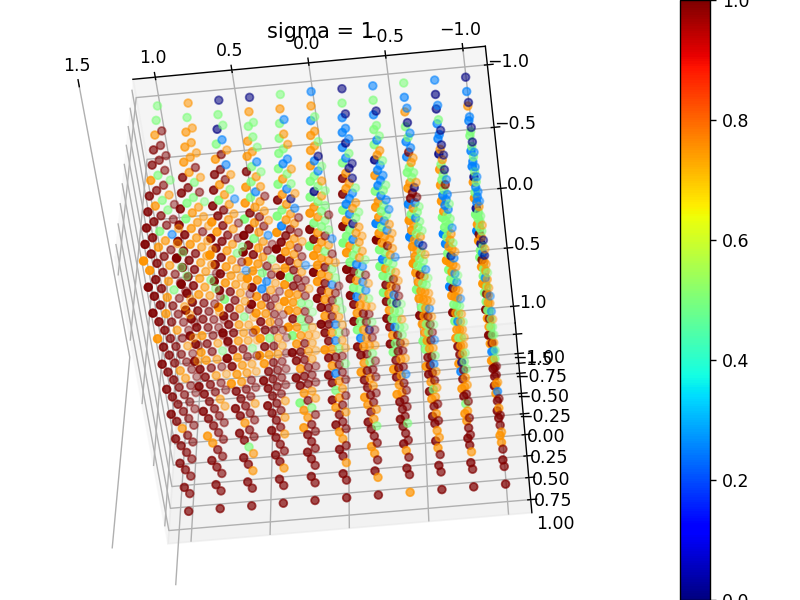

<IPython.core.display.Javascript object>


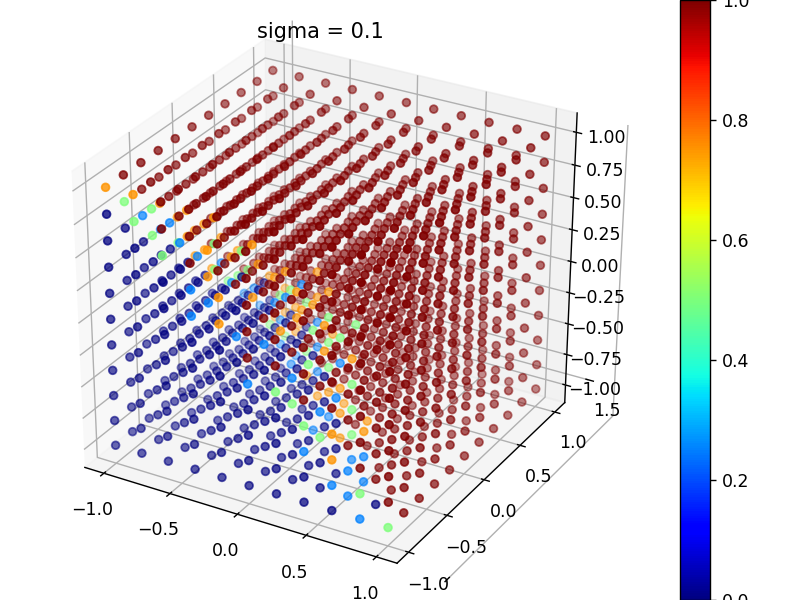

<IPython.core.display.Javascript object>


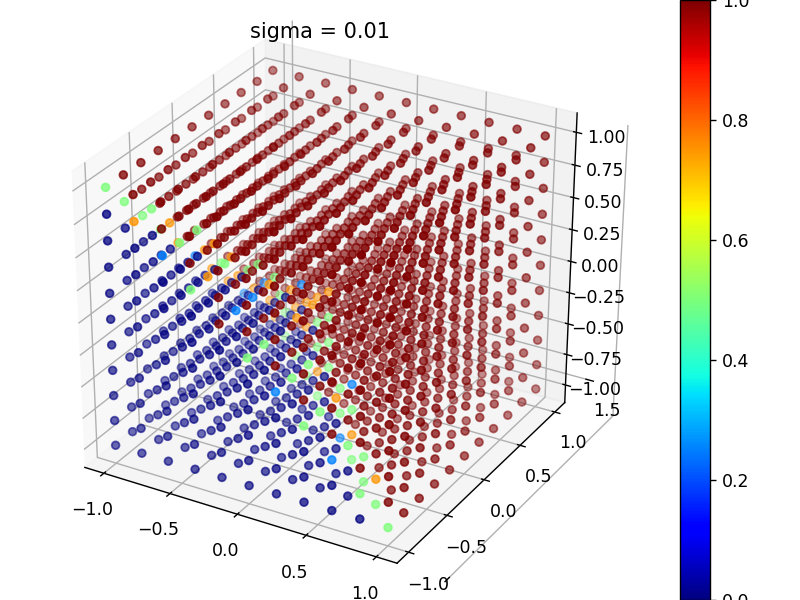

In [121]:
initial_partition_type = "0"
for sigma in sigmas:
    x, f = MeshGrid3dMaxCut(k, min_weight, max_weight, initial_partition_type, n_points_ax, n_iters, complexity, heuristic, sigma)
    title = "sigma = " + str(sigma)
    PlotMeshGrid3d(x, -1*f, title)

#### Dependendcy on k

##### Random grid

###### Main parameters

In [19]:
## Define grid parameters
# Nodes
min_nodes = 10
max_nodes = 30
num_nodes = 6

# Dropout assumed to be 0
dropout = 0

# K-cuts
ks=[2]

# Weights range
min_weight = -1
max_weight = 1

# Weight perturbation (smoothed complexity)
sigma = 0.05

# Number of instances for each combination
iters_for_nk= 10

# iters_for_w
iters_for_w = 50

n_perturbations = 50

# Heuristic
heuristic = "GBF"

# partition
initial_partition_type = "0"

###### Run

In [ ]:
#nodes, smoothed_complexities = RandomGridSmoothedComplexityK(min_nodes, max_nodes, num_nodes, initial_partition_type, ks, dropout, 
#                                  min_weight, max_weight, iters_for_nk, iters_for_w, heuristic, sigma)

nodes, smoothed_complexities = RandomGridSmoothedComplexityParallelK(min_nodes, max_nodes, num_nodes, initial_partition_type, ks, dropout, 
                                  min_weight, max_weight, n_perturbations, iters_for_w, heuristic, sigma)

##### Basinhopping algorithm

###### Main parameters

In [54]:
## Define grid parameters
# Nodes
min_nodes = 10
max_nodes = 20
num_nodes = 2

# Dropout assumed to be 0
dropout = 0

# K-cuts
ks=[2]

# Weights range
min_weight = -1
max_weight = 1

# Weight perturbation (smoothed complexity)
sigma = 0.05

# Number of instances for each combination
iters_for_nk= 10

# iters_for_w
iters_for_w = 100

# Heuristic
heuristic = "GBF"

# n_iterations basinhopping
n_iterations = 10

initial_partition_type = "0"

###### Run

In [60]:
nodes, smoothed_complexities = BasinHoppingSmoothedComplexityK(min_nodes, max_nodes, num_nodes, initial_partition_type, ks, dropout, 
                                min_weight, max_weight, iters_for_nk, heuristic, sigma, n_iterations)

KeyboardInterrupt: 

##### Random optimization

###### Main parameters

In [65]:
## Define grid parameters
# Nodes
min_nodes = 5
max_nodes = 30
num_nodes = 10

# Dropout assumed to be 0
dropout = 0

# K-cuts
ks=[2]

# Weights range
min_weight = -1
max_weight = 1

# Weight perturbation (smoothed complexity)
sigma = 0.01

# Weight perturbation random search ("step size")
e = 0.8

# Decay of step size
decay = 0.001

# Number of times we perturbate the weights per step
iters_for_perturbation= 20

# Method
heuristic = "GBF"

# n iterations of algorithm
n_iterations = 30

# Tries random search
tries = 20

# partition
initial_partition_type = "0"

###### Run

In [66]:
nodes, smoothed_complexities = RandomOptimizationSmoothedComplexityK(min_nodes, max_nodes, num_nodes, initial_partition_type, ks, 
                                  min_weight, max_weight, n_iterations, tries, heuristic, iters_for_perturbation, e, decay, sigma)
#nodes, smoothed_complexities = RandomOptimizationSmoothedComplexityParallelK(min_nodes, max_nodes, num_nodes, initial_partition_type, ks, 
#                                  min_weight, max_weight, n_iterations, tries, heuristic, iters_for_perturbation, e, decay, sigma)

Best result for n=4 and k=2 is 3.0
Best result for n=6 and k=2 is 5.0
Best result for n=7 and k=2 is 7.0
Best result for n=9 and k=2 is 8.0
Best result for n=11 and k=2 is 10.35
Best result for n=13 and k=2 is 11.025
Best result for n=16 and k=2 is 10.3
Best result for n=20 and k=2 is 15.475
Best result for n=24 and k=2 is 15.6
Best result for n=29 and k=2 is 21.0


##### Show results

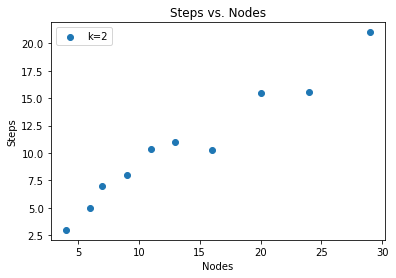

In [67]:
PlotResults(nodes, smoothed_complexities, [], False, ks, 'k')

##### Polynomial behavior

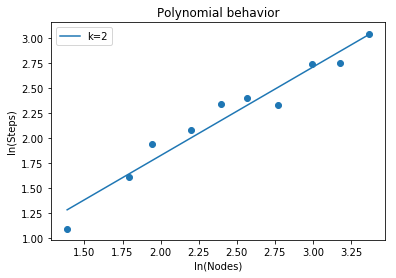

Regression results:

  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    0.883        0.061      0.975


In [68]:
slopes, intercepts = PlotRegressionResults(nodes, smoothed_complexities, [], False, ks, 'k', "polynomial")

##### Exponential behavior

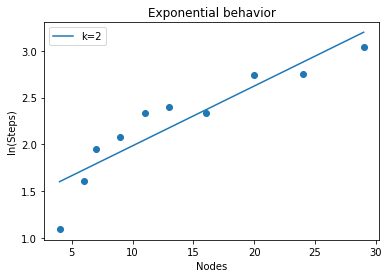

Regression results:

  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    0.064        1.345      0.912


In [69]:
slopes, intercepts = PlotRegressionResults(nodes, smoothed_complexities, [], False, ks, 'k', "exponential")

#### Dependency on heuristics

##### Main parameters

In [ ]:
## Define grid parameters
# Nodes
min_nodes = 5
max_nodes = 100
num_nodes = 20

# Dropout assumed to be 0
dropout = 0

# K-cuts
k=2

# Weights range
min_weight = -1
max_weight = 1

# Perturbation
sigma = 0.05

# Number of instances for each combination
iters_for_nk= 50

# iters_for_w
iters_for_w = 50

# Method
heuristics = ["GBF", "RPF", "WF"]

# n iterations of basinhopping
n_iterations = 10

# partition
initial_partition_type = "random"

##### Run

In [ ]:
nodes, smoothe_complexities = RandomSearchSmoothedComplexityHeuristics(min_nodes, max_nodes, step_nodes, k, dropout, 
                                  min_weight, max_weight, iters_for_nk, iters_for_w, heuristics, sigma)

##### Show results

In [ ]:
PlotResults(nodes, smoothed_complexities, [], False, heuristics, 'h')

##### Polynomial behavior

In [ ]:
slopes, intercepts = PlotRegressionResults(nodes, smoothed_complexities, [], False, heuristics, 'h', "polynomial")

##### Exponential behavior

In [ ]:
slopes, intercepts = PlotRegressionResults(nodes, smoothed_complexities, [], False, heuristics, 'h', "exponential")

#### Dependency on sigma

##### Main parameters

In [ ]:
## Define grid parameters
# Nodes
min_nodes = 5
max_nodes = 100
num_nodes = 20

# Dropout assumed to be 0
dropout = 0

# K-cuts
k=2

# Weights range
min_weight = -1
max_weight = 1

# Perturbation
sigmas = [0.001, 0.01, 0.1]

# Number of instances for each combination
iters_for_nk= 50

# iters_for_w
iters_for_w = 50

# Method
method = "GBF"

# n iterations of basinhopping
n_iterations = 10

# Partition
initial_partition_type = "random"

##### Run

In [ ]:
nodes, smoothed_complexities = RandomSearchSmoothedComplexitySigmas(min_nodes, max_nodes, step_nodes, initial_partition_type, k, dropout, 
                                  min_weight, max_weight, iters_for_nk, iters_for_w, heuristic, sigmas)

##### Polynomial behavior

In [ ]:
slopes, intercepts = PlotRegressionResults(nodes, smoothed_complexities, [], False, sigmas, 'sigma', "polynomial")

##### Exponential behavior

In [ ]:
slopes, intercepts = PlotRegressionResults(nodes, smoothed_complexities, [], False, sigmas, 'sigma', "exponential")

### Partial graph (dropout)

#### Define main parameters

In [ ]:
## Define grid parameters
# Nodes
min_nodes = 5
max_nodes = 100
num_nodes = 20

# Dropout assumed to be 0
dropouts = np.linspace(0.1, 0.9, 9)

# K-cuts
k=2

# Weights range
min_weight = -1
max_weight = 1

# Perturbation
sigma = 0.05

# Number of instances for each combination
iters_for_nk= 50

# iters_for_w
iters_for_w = 50

# Method
heuristics = "FBF"

# n iterations of basinhopping
n_iterations = 10

#### Run

In [ ]:
nodes, smoothed_complexities_d = RandomSearchSmoothedComplexityDropout(min_nodes, max_nodes, step_nodes, k, dropouts, 
                                  min_weight, max_weight, iters_for_nk, iters_for_w, heuristic, sigma)

##### Show results

In [ ]:
PlotResults(nodes, smoothed_complexities_d, [], False, dropouts, 'd')

##### Polynomial behavior

In [ ]:
slopes, intercepts = PlotRegressionResults(nodes, smoothed_complexities_d, [], False, dropouts, 'd', "polynomial")

##### Exponential behavior

In [ ]:
slopes, intercepts = PlotRegressionResults(nodes, smoothed_complexities_d, [], False, dropouts, 'd', "exponential")